In [1]:
import xarray as xr
import numpy as np
import cftime
import nc_time_axis
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
from cftime import datetime 
import matplotlib.colors as colors
import math
import random
import matplotlib.cm as mcm
jet = mcm.get_cmap('jet')
jet_r = mcm.get_cmap('jet_r')
import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dateutil import tz
import pytz
%matplotlib inline 

filename="Nc_Files/Wuhu_WACCMX_files/Wuhu_WACCMX_run_Feb_day1.ncdf"
Metal = 'Fe'
ds = xr.open_dataset(filename)
#ds

In [2]:
time = ds.variables['time']
times = xr.cftime_range(start="0001-02-01", periods=25, freq="1H", calendar="noleap")
times2 = ds["time"].dt.strftime("%Y%m%d %H:%M")
times3 = ds["time"].dt.strftime("%Y%m%d")

#times
#times2
#times3

In [3]:
lon = ds.variables['lon']
lat = ds.variables['lat']
lev = ds.variables['lev']

dst = ds.transpose("lev", ...)

Mt = dst.variables[str(Metal)]
Mpt = dst.variables[str(Metal)+'p']
temp = dst.variables['T']
elect = dst.variables['e']

geopH = dst.variables['Z3'] / 1000 #m-> km
Zavg = geopH.mean(('time','lat', 'lon'))

#Mt[:,1,1,1]
#lev
#dst
#geopH[-1,1,1,1]
#temp
#lat

In [4]:
edens = ( elect * 1e-6 * 100 * lev ) / (1.380503e-23 * temp) # cm-3
edens_m3 = edens * 1e6 # cm-3 -> m-3
#edens #lev: 126 time: 672 lat: 96 lon: 144

In [5]:
Nem = edens_m3.max('lev', keep_attrs=True)  #find maximum e density (m-3) along lev axis    
Nem_ind = edens_m3.argmax('lev', keep_attrs=True) #find indices of max e density (m-3) along lev axis 

#Nem_ind  
#Nem

In [6]:
#Calculate critical ionosonde frequency
#For freqs at or below FoEs, the wave gets reflected from ionosphere. Above FoEs, waves penetrate through the ionosphere

foEs = 8.98 * np.sqrt(Nem) #Hz

foEs = foEs / 1e6 #MHz

#foEs #time: 672 lat: 96 lon: 144

In [7]:
foEs_max = foEs.max({'lat','lon','time'}, keep_attrs=True)  #find maximum (17.76439987)
#print(foEs_max)

#foEs_maxind = foEs.argmax({'time', 'lat', 'lon'}, keep_attrs=True)
#print(foEs_maxind)

In [9]:
#-----Set up plot variables for plot 1: FoEs ------

time_plot_ind = 3
time_plot_str = str(times[time_plot_ind])
time_plot_str2 = str(time_plot_str[0:13])+'h'

foEs_plot = foEs[time_plot_ind,:,:]

print(time_plot_str2)
print(foEs_plot)

0001-02-01 03h
<xarray.Variable (lat: 96, lon: 144)>
array([[5.61223046, 5.61222418, 5.61222749, ..., 5.6122172 , 5.61222173,
        5.61222644],
       [5.58604173, 5.58520539, 5.58435625, ..., 5.5888989 , 5.58788918,
        5.58697968],
       [5.58256368, 5.57879582, 5.57529261, ..., 5.59387666, 5.59010595,
        5.58640298],
       ...,
       [6.00564397, 5.99947964, 5.99404476, ..., 6.02924917, 6.02050956,
        6.01267833],
       [6.21794331, 6.2166906 , 6.21579435, ..., 6.22401356, 6.22174157,
        6.21962413],
       [6.40232387, 6.40246597, 6.40243755, ..., 6.4024158 , 6.40238492,
        6.4023544 ]])


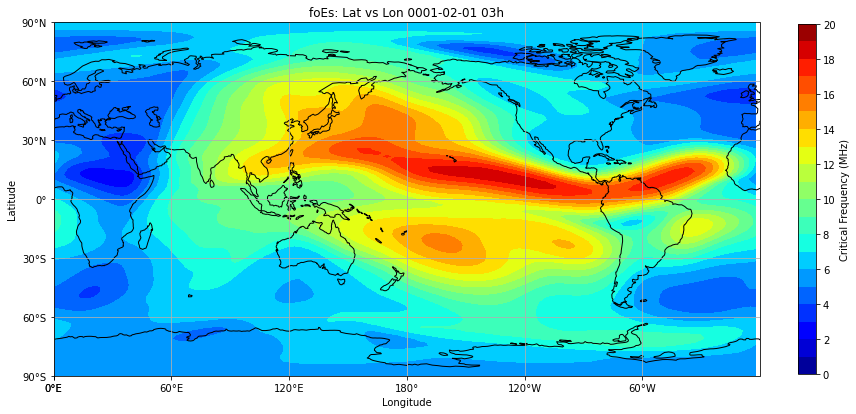

In [23]:
#------------------------Plot 1: FoEs-----------------------------

#ticks = np.geomspace(1*10**3, 2*10**4)
ticks = np.linspace(0,20,21)

fig = plt.figure(figsize=(12,8))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_global()

C = plt.contourf(lon, lat, foEs_plot, 
                 levels=ticks,
                 transform=ccrs.PlateCarree(),
                 #locator=ticker.LogLocator(),
                 #extend='both',
                 cmap=jet)

ax.coastlines() 
ax.gridlines()

ax.set_xlabel('Longitude')

#ax.set_xticks([0, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180], crs=ccrs.PlateCarree())
ax.set_xticks([0, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())  
ax.set_ylabel('Latitude')
ax.set_title('foEs: Lat vs Lon ' + time_plot_str2)

#------------------
#def fmt(x, pos):
#    a, b = '{:.1e}'.format(x).split('e')
#    b = int(b)
#    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, fraction=0.023, pad=0.05,ticks=ticks[::2]) #,format=ticker.FuncFormatter(fmt)
#-------------------
#cbar = fig.colorbar(C)#,format='%.0e', fraction=0.023, pad=0.05)  #,ticks=ticks[::2]

cbar.set_label(r'Critical Frequency (MHz)')

figname='foEs: Lat vs Lon '+ time_plot_str2 + '.png'
plt.savefig('./Figures/Wuhu_run/'+str(figname), dpi = 300) #
plt.tight_layout()
plt.show()

In [24]:
timear = np.arange(0,25)
latar = np.arange(0,96)
lonar = np.arange(0,144)

In [25]:
hmF2 = Nem # set hmF2 to max e dens so that it becomes an xarray object with same dims
for k in lonar:
    for j in latar:
        for i in timear:       
            hmF2[i,j,k] = lev[ int(Nem_ind[i,j,k]) ]  #HPa
hmF2

<xarray.Variable (time: 26, lat: 96, lon: 144)>
array([[[4.44700196e-07, 4.44700196e-07, 4.44700196e-07, ...,
         4.44700196e-07, 4.44700196e-07, 4.44700196e-07],
        [4.44700196e-07, 4.44700196e-07, 4.44700196e-07, ...,
         4.44700196e-07, 4.44700196e-07, 4.44700196e-07],
        [4.44700196e-07, 4.44700196e-07, 4.44700196e-07, ...,
         4.44700196e-07, 4.44700196e-07, 4.44700196e-07],
        ...,
        [1.27408739e-07, 1.27408739e-07, 1.27408739e-07, ...,
         1.27408739e-07, 1.27408739e-07, 1.27408739e-07],
        [1.27408739e-07, 1.27408739e-07, 1.27408739e-07, ...,
         1.27408739e-07, 1.27408739e-07, 1.27408739e-07],
        [1.27408739e-07, 1.27408739e-07, 1.27408739e-07, ...,
         1.27408739e-07, 1.27408739e-07, 1.27408739e-07]],

       [[3.46332861e-07, 3.46332861e-07, 3.46332861e-07, ...,
         3.46332861e-07, 3.46332861e-07, 3.46332861e-07],
        [3.46332861e-07, 3.46332861e-07, 3.46332861e-07, ...,
         3.46332861e-07, 3.46332861e-07, 3.46332861e-07],
        [3.46332861e-07, 3.46332861e-07, 3.46332861e-07, ...,
         3.46332861e-07, 3.46332861e-07, 3.46332861e-07],
...
        [9.92260259e-08, 9.92260259e-08, 9.92260259e-08, ...,
         9.92260259e-08, 9.92260259e-08, 9.92260259e-08],
        [9.92260259e-08, 9.92260259e-08, 9.92260259e-08, ...,
         9.92260259e-08, 9.92260259e-08, 9.92260259e-08],
        [9.92260259e-08, 9.92260259e-08, 9.92260259e-08, ...,
         9.92260259e-08, 9.92260259e-08, 9.92260259e-08]],

       [[3.46332861e-07, 3.67124412e+11, 3.67123993e+11, ...,
         3.67127763e+11, 3.67127915e+11, 3.67059990e+11],
        [3.50807767e+11, 3.51891663e+11, 3.52619946e+11, ...,
         3.49816077e+11, 3.50094001e+11, 3.50437182e+11],
        [3.60403287e+11, 3.61230756e+11, 3.62338155e+11, ...,
         3.59661414e+11, 3.59935869e+11, 3.60368273e+11],
        ...,
        [7.09034138e+11, 7.05155692e+11, 7.01010222e+11, ...,
         7.22217137e+11, 7.16908202e+11, 7.12830081e+11],
        [7.43959568e+11, 7.42424507e+11, 7.40793136e+11, ...,
         7.48180426e+11, 7.46981267e+11, 7.45569092e+11],
        [7.91999788e+11, 7.92053042e+11, 7.92045203e+11, ...,
         7.92035234e+11, 7.92021857e+11, 7.92009843e+11]]])

In [26]:
#-----Set up plot variables for plot 2: hmF2 ------

time_plot2_ind = 3
time_plot2_str = str(times[time_plot_ind])
time_plot2_str2 = str(time_plot_str[0:13])+'h'

hmF2_plot = hmF2[time_plot2_ind,:,:]

print(time_plot2_str2)
print(hmF2_plot)

0001-02-01 03h
<xarray.Variable (lat: 96, lon: 144)>
array([[2.10061498e-07, 2.10061498e-07, 2.10061498e-07, ...,
        2.10061498e-07, 2.10061498e-07, 2.10061498e-07],
       [1.63596060e-07, 1.63596060e-07, 1.63596060e-07, ...,
        1.63596060e-07, 1.63596060e-07, 1.63596060e-07],
       [1.63596060e-07, 1.63596060e-07, 1.63596060e-07, ...,
        1.63596060e-07, 1.63596060e-07, 1.63596060e-07],
       ...,
       [9.92260259e-08, 9.92260259e-08, 9.92260259e-08, ...,
        9.92260259e-08, 9.92260259e-08, 9.92260259e-08],
       [9.92260259e-08, 9.92260259e-08, 9.92260259e-08, ...,
        9.92260259e-08, 9.92260259e-08, 9.92260259e-08],
       [9.92260259e-08, 9.92260259e-08, 9.92260259e-08, ...,
        9.92260259e-08, 9.92260259e-08, 9.92260259e-08]])


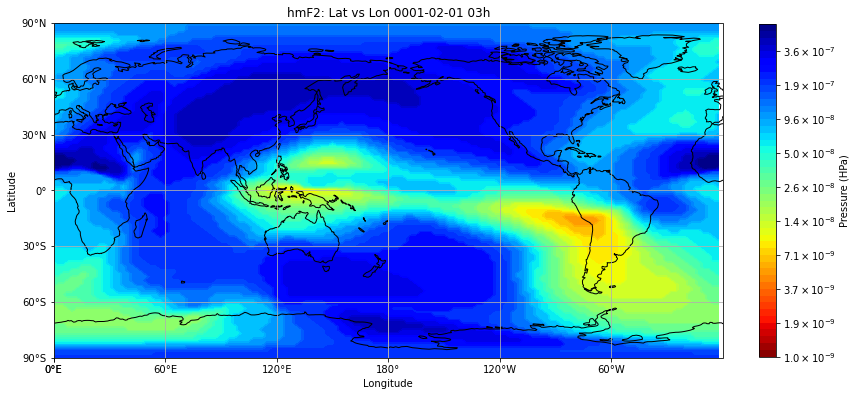

In [32]:
#------------------------Plot 2: hmF2-----------------------------

ticks = np.geomspace(1*10**-9, 6*10**-7)

fig = plt.figure(figsize=(12,8))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_global()

C = plt.contourf(lon, lat, hmF2_plot, 
                 levels=ticks,
                 transform=ccrs.PlateCarree(),
                 locator=ticker.LogLocator(),
                 #extend='both',
                 cmap=jet_r)

ax.coastlines() 
ax.gridlines()

ax.set_xlabel('Longitude')

#ax.set_xticks([0, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180], crs=ccrs.PlateCarree())
ax.set_xticks([0, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())  
ax.set_ylabel('Latitude')
ax.set_title('hmF2: Lat vs Lon ' + time_plot_str2)


#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C,format=ticker.FuncFormatter(fmt), fraction=0.023, pad=0.05) #
#-------------------
#cbar = fig.colorbar(C)#,format='%.0e', fraction=0.023, pad=0.05)  #,ticks=ticks[::2]

cbar.set_label(r'Pressure (HPa)')

figname='hmF2: Lat vs Lon '+ time_plot_str2 + '.png'
plt.savefig('./Figures/Wuhu_run/'+str(figname), dpi = 300) #
plt.tight_layout()
plt.show()

In [49]:
#-----Set up plot variables for plot 3: Nem ------

time_plot3_ind = 3
time_plot3_str = str(times[time_plot_ind])
time_plot3_str2 = str(time_plot_str[0:13])+'h'

Nem_plot = Nem[time_plot3_ind,:,:]        #m-3
Nem_plot_cm3 = Nem_plot * 1e6  #cm-3

print(time_plot3_str2)
print(Nem_plot_cm3)  

0001-02-01 03h
<xarray.Variable (lat: 96, lon: 144)>
array([[0.2100615 , 0.2100615 , 0.2100615 , ..., 0.2100615 , 0.2100615 ,
        0.2100615 ],
       [0.16359606, 0.16359606, 0.16359606, ..., 0.16359606, 0.16359606,
        0.16359606],
       [0.16359606, 0.16359606, 0.16359606, ..., 0.16359606, 0.16359606,
        0.16359606],
       ...,
       [0.09922603, 0.09922603, 0.09922603, ..., 0.09922603, 0.09922603,
        0.09922603],
       [0.09922603, 0.09922603, 0.09922603, ..., 0.09922603, 0.09922603,
        0.09922603],
       [0.09922603, 0.09922603, 0.09922603, ..., 0.09922603, 0.09922603,
        0.09922603]])


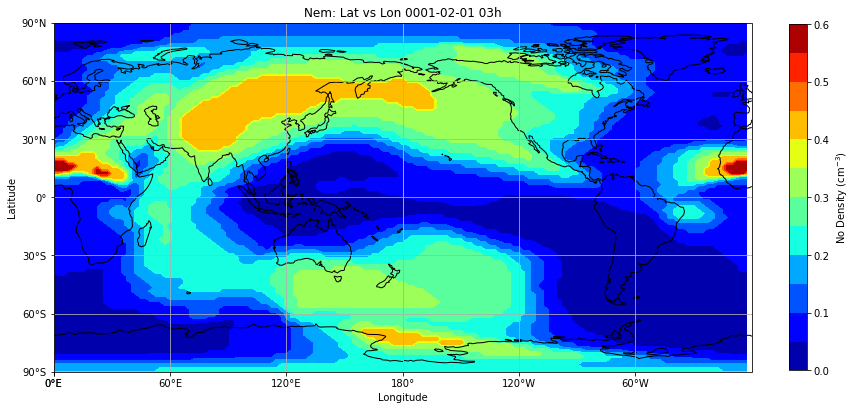

In [54]:
#------------------------Plot 3: Nem-----------------------------

ticks = np.linspace(0,0.6,13)

fig = plt.figure(figsize=(12,8))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_global()

C = plt.contourf(lon, lat, Nem_plot_cm3, 
                 levels=ticks,
                 transform=ccrs.PlateCarree(),
                 #locator=ticker.LogLocator(),
                 #extend='both',
                 cmap=jet)

ax.coastlines() 
ax.gridlines()

ax.set_xlabel('Longitude')

#ax.set_xticks([0, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180], crs=ccrs.PlateCarree())
ax.set_xticks([0, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())  
ax.set_ylabel('Latitude')
ax.set_title('Nem: Lat vs Lon ' + time_plot_str2)


#------------------
#def fmt(x, pos):
#    a, b = '{:.1e}'.format(x).split('e')
#    b = int(b)
#    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, fraction=0.023, pad=0.05) #,format=ticker.FuncFormatter(fmt)
#-------------------
#cbar = fig.colorbar(C)#,format='%.0e', fraction=0.023, pad=0.05)  #,ticks=ticks[::2]

cbar.set_label(r'No Density (cm$^{-3}$)')

figname='Nem: Lat vs Lon '+ time_plot_str2 + '.png'
plt.savefig('./Figures/Wuhu_run/'+str(figname), dpi = 300) #
plt.tight_layout()
plt.show()

In [67]:
print(ticks)
print(ticks.size)

[1.00000000e-09 1.15139540e-09 1.32571137e-09 1.52641797e-09
 1.75751062e-09 2.02358965e-09 2.32995181e-09 2.68269580e-09
 3.08884360e-09 3.55648031e-09 4.09491506e-09 4.71486636e-09
 5.42867544e-09 6.25055193e-09 7.19685673e-09 8.28642773e-09
 9.54095476e-09 1.09854114e-08 1.26485522e-08 1.45634848e-08
 1.67683294e-08 1.93069773e-08 2.22299648e-08 2.55954792e-08
 2.94705170e-08 3.39322177e-08 3.90693994e-08 4.49843267e-08
 5.17947468e-08 5.96362332e-08 6.86648845e-08 7.90604321e-08
 9.10298178e-08 1.04811313e-07 1.20679264e-07 1.38949549e-07
 1.59985872e-07 1.84206997e-07 2.12095089e-07 2.44205309e-07
 2.81176870e-07 3.23745754e-07 3.72759372e-07 4.29193426e-07
 4.94171336e-07 5.68986603e-07 6.55128557e-07 7.54312006e-07
 8.68511374e-07 1.00000000e-06]
50


In [70]:
tick_test = np.linspace(1.0e-9,1.0e-6,50)
print(tick_test)
print(tick_test.size)

[1.00000000e-09 2.13877551e-08 4.17755102e-08 6.21632653e-08
 8.25510204e-08 1.02938776e-07 1.23326531e-07 1.43714286e-07
 1.64102041e-07 1.84489796e-07 2.04877551e-07 2.25265306e-07
 2.45653061e-07 2.66040816e-07 2.86428571e-07 3.06816327e-07
 3.27204082e-07 3.47591837e-07 3.67979592e-07 3.88367347e-07
 4.08755102e-07 4.29142857e-07 4.49530612e-07 4.69918367e-07
 4.90306122e-07 5.10693878e-07 5.31081633e-07 5.51469388e-07
 5.71857143e-07 5.92244898e-07 6.12632653e-07 6.33020408e-07
 6.53408163e-07 6.73795918e-07 6.94183673e-07 7.14571429e-07
 7.34959184e-07 7.55346939e-07 7.75734694e-07 7.96122449e-07
 8.16510204e-07 8.36897959e-07 8.57285714e-07 8.77673469e-07
 8.98061224e-07 9.18448980e-07 9.38836735e-07 9.59224490e-07
 9.79612245e-07 1.00000000e-06]
50
